In [1]:
#=======================================================================
# RECONSTRUCT INDO-PACIFIC SST PATTERNS USING PRECIPITATION PROXIES
# IN A COVARIANCE MODELING FRAMEWORK.

# METR 5433 EXAMPLE

# BACKGROUND
# Reconstruct tropical Pacific sea surface temperature anomalies using
# precipitation data from select location where paleoclimate records are found.
# The goal here is that - we don't have actual measurements of SSTs in the past,
# but there are ways to measure SSTs using paleoclimate proxies like corals. But,
# those corals are also sensitive to other variables including precipitation.
# Moreover, those corals measure SSTs LOCALLY, while we wish to reconstruct
# SSTs throughout the Indo-Pacific region, for example. As such, we need to
# take a MULTI-PROXY approach. The other variable correlated with SSTs in the
# tropics is precipitation (the first-order balance in the tropics is between
# low-level heating and convection. Therefore, we will use the location of
# several proxies throughout the Indo-Pacific region that measures precipitation
# variability in the past. We will thus test how well precipitation in specific
# locations can reconstruct the SST field using COVARIANCE MODELING, where we
# calculate the covariance between precipitation at SPECIFIC locations with the SST
# anomalies THROUGHOUT THE BASIN.
#=======================================================================

In [29]:
#=======================================================================
# Import the necessary libraries.
#=======================================================================
import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.basemap import Basemap,cm,shiftgrid
from datetime import datetime
from scipy import stats,interpolate
from LoadMATFile import LoadMATFile

In [3]:
#=======================================================================
# Load the precipitation anomalies. For this exercise, we will use CMAP precipitation
# data from 1979-2000. We will also be using annual-mean precipitation anomalies.
#=======================================================================
years = np.arange(1979,2001)
precip = LoadMATFile('CMAP_avgprecip_annual_7900.mat')

#=======================================================================
# Load the SSTa data. These are HadISST from 1979-2000 and are annual averages.
# The SST data have also been smoothed with a 5 point spatial smoother.
#=======================================================================
sst = LoadMATFile('HadISST_SSTA_annual_7900_5PTAVG.mat')

#Take every other grid point to match the precip resolution.
sst['annussta'] = sst['annussta'][::2,::2,:]
sst['lon'] = sst['lon'][::2,::2]
sst['lat'] = sst['lat'][::2,::2]

In [4]:
#=======================================================================
# Load the "proxy network" -- These are locations where there are paleoclimate
# proxies that measure (annual-mean) precipitation records in various locations
# around the tropical and subtropical regions.
#=======================================================================
locations = {}

# Tree Rings
locations['TreeRings'] = {}
locations['TreeRings']['names'] = ['El Vado','Mzola Forest','Nevado','Villa Real',\
                          'Baobab Hole','Bigin','Sikumi']
locations['TreeRings']['lon'] = np.array([-96.,-333.,-103.,-97.,-334.,-249.,-334.])
locations['TreeRings']['lat'] = np.array([16.,-18.,19.,19.,-18.,-7.-18.])

# Corals
locations['Corals'] = {}
locations['Corals']['names'] = ['Aqaba AQ18','Cebu CEB','Secas Island SEC',\
                       'Kiritimati KIR','Tarawa Atoll TAR','Urvina Bay URV',\
                       'Punta Pitt PUN','Mehe, Seychelles MAH','Espiritu Santo ESP',\
                       'New Caledonia CAL','Abraham Reef ABR','Amedee Lighthouse',\
                       'Brittomart / Brook Island','Bunaken','Clipperton','Houtman',\
                       'Ifaty Reef','La Parguera','Laing Island','Lombok Strait','Madang',\
                       'Maiana','Malindi','Moorea Lagoon','Nauru','Ningaloo Reef',\
                       'Palmyra Island','Rarotonga Island','Saint Gilles']
locations['Corals']['lon'] = np.array([-325.,-236.,-82.,-157.,-188.,-91.2,-89.,\
                             -304.2,-193.,-193.8,-207.,-194.,-214.,-236.,-109.,-247.,\
                             -217.,-67.,-216.,-245.,-215.,-187.,-40.,-149.,-194.,-247.,\
                             -162.,-201.,-305.])
locations['Corals']['lat'] = np.array([29.5,10.,8.,2.,1.,-0.4,-0.7,-4.6,-15.,-20.7,-22.,\
                             -22.,-18.,1.,10.,-28.,-23.,17.,-4.,-8.,-5.,1.,-3.,-17.,0.,-21.,6.,\
                             -21.,-21.])

# Lake Records
locations['LakeRecords'] = {}
locations['LakeRecords']['names'] = ['Lake Peten-Itza','Lake Valencia']
locations['LakeRecords']['lon'] = np.array([-89.,-66.])
locations['LakeRecords']['lat'] = np.array([16.,10.])

# Speleothems
locations['Speleothems'] = {}
locations['Speleothems']['names'] = ['Borneo']
locations['Speleothems']['lon'] = np.array([-245.])
locations['Speleothems']['lat'] = np.array([4.])

# Sediments
locations['Sediments'] = {}
locations['Sediments']['names'] = ['Cariaco Basin','Peru Lithics','Midano Strait']
locations['Sediments']['lon'] = np.array([-65.,-77.,-233.])
locations['Sediments']['lat'] = np.array([10.,-12.,7.])

# Glaciers
locations['Glaciers'] = {}
locations['Glaciers']['names'] = ['Kilimangaro','Huascaran','Quelccaya','Felidhu']
locations['Glaciers']['lon'] = np.array([-323.,-77.,-70.,-286.5])
locations['Glaciers']['lat'] = np.array([-3.,-9.,-13.,3.5])


In [5]:
#=======================================================================
# Function to detrend data. y must be provided as time x space.
#=======================================================================
def Detrend(y):
    time = np.arange(y.shape[0])
    
    E = np.ones((y.shape[0],2))
    E[:,0] = time
    
    invETE = np.linalg.inv(np.dot(E.T,E))
    xhat = invETE.dot(E.T).dot(y)
    trend = np.dot(E,xhat)
    detrendedData = y - trend
    
    return detrendedData,trend


In [6]:
#=======================================================================
# Detrend the precipitation anomalies and SSTa at each grid point to avoid
# trends from influencing the covariance.
#=======================================================================
I,J,T = precip['annuprecipa'].shape
y = precip['annuprecipa'].reshape(I*J,T,order='F').T
dprecip = Detrend(y)[0]
dprecip = dprecip.T.reshape(I,J,T,order='F')

I,J,T = sst['annussta'].shape
y = sst['annussta'].reshape(I*J,T,order='F').T
dssta = Detrend(y)[0]
dssta = dssta.T.reshape(I,J,T,order='F')


In [7]:
#=======================================================================
# Narrow the domain we are interested in to +/- 30.
#=======================================================================
inprecip = np.where(abs(precip['plat'])<=32)[0]
insst = np.where(abs(sst['lat'][0,:])<=30)[0]

plat,plon = np.meshgrid(precip['plat'][inprecip],precip['plon']-360.)
sstlat,sstlon = sst['lat'][:,insst],sst['lon'][:,insst]


In [25]:
#=======================================================================
# Now find the closest points in the precip array next to the proxy locations.
# We will use the Euclidean distance for this, but there are built-in functions
# as well that could be used.
#=======================================================================
inProxy = [] # Hold the SPACE point where the proxy lives in the precipitation grid.
I,J = plon.shape
plon2 = plon.reshape(I*J,order='F')
plat2 = plat.reshape(I*J,order='F')

proxylon,proxylat = [],[]
for k in locations.keys():
    for ilon,ilat in zip(locations[k]['lon'],locations[k]['lat']):
        proxylon.append(ilon); proxylat.append(ilat)
        dist = (ilon-plon2)**2 + (ilat-plat2)**2
        inProxy.append(np.argmin(dist))

inProxy = np.array(inProxy)

In [26]:
#=======================================================================
# Set up the x and y matrices for the covariance model. x = precip, y = sst
#=======================================================================
I,J,T = dprecip[:,inprecip,:].shape
x = dprecip[:,inprecip,:].reshape(I*J,T,order='F')[inProxy,:]

I,J,T = dssta[:,insst,:].shape
ssta = dssta[:,insst,:].reshape(I*J,T,order='F')
notSSTNaN = ~np.isnan(ssta[:,0])
y = ssta[notSSTNaN,:]


In [40]:
#=======================================================================
# Now use multiple iterations to build E and reconstruct the SSTs.
# In each iteration, we will randomly grab 11 years and use that for
# the model. Then, we will use the model to predict the SSTs for the remaining
# years.
#=======================================================================
niter = 200
rms_err = np.ones((I*J,niter))*np.nan
rpattern = np.ones((T,niter))*np.nan

for it in range(niter):
    idx = np.random.choice(len(years),11,replace=False)
    Cxx = np.dot(x[:,idx],x[:,idx].T)/11.
    Cyy = np.dot(y[:,idx],y[:,idx].T)/11.
    Cyx = np.dot(y[:,idx],x[:,idx].T)/11.

    #Avoid Singular matrix. "Condition" the matrix for inversion.
    l = np.diag(np.ones_like(x[:,0]))*1e-10
    Cxxi = np.linalg.inv(Cxx+l)

    E = np.dot(Cyx,Cxxi)
    
    # Find the years NOT used in the model building and forecast
    # for those years.
    idx2 = np.array([i for i in range(len(years)) if i not in idx])
    yhat = np.dot(E,x[:,idx2])
    
    rms_err[notSSTNaN,it] = np.sqrt(np.nanmean((yhat-y[:,idx2])**2,-1))
    for n,i in enumerate(idx2):
        cov = np.dot(y[:,i].T,yhat[:,n])/float(y.shape[0])
        std1 = np.sqrt(np.nanmean(y[:,i]**2))
        std2 = np.sqrt(np.nanmean(yhat[:,n]**2))
        
        rpattern[i,it] = cov/std1/std2
        #rpattern[i,it] = stats.pearsonr(y[:,i],yhat[:,n])[0]


/Users/jfurtado/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


[ 0.35216022  0.1340487   0.25413391  0.57464514  0.72043556  0.65233493
  0.69009753  0.39817639  0.63523867  0.62294768  0.65036936  0.30114114
  0.49511526  0.45545706  0.59794762  0.6841781   0.49602147  0.44785682
  0.74823361  0.60322372  0.80033853  0.71893953]


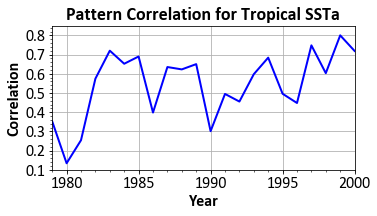

In [42]:
#=======================================================================
# Compute the error statistics to get the skill.
#=======================================================================
meanR = np.nanmean(rpattern,-1)
meanRMS = np.nanmean(rms_err,-1)
skill = 1. - meanRMS/np.nanstd(ssta,-1)
skill = skill.reshape(I,J,order='F')

print meanR


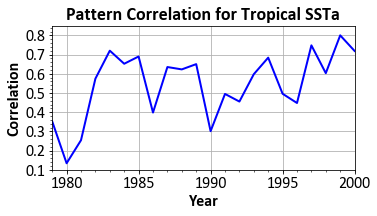

In [44]:
#=======================================================================
# Make a plot of the results
#=======================================================================
#PATTERN CORRELATION
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.7,0.5])
ax.plot(years,meanR,'b-',lw=2)
ax.set(xlim=[1979,2000],ylim=[0.1,0.85],xticks=np.arange(1980,2001,5),\
      yticks=np.arange(0.1,0.9,0.1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.set_title('Pattern Correlation for Tropical SSTa',name='Calibri',\
             size=18,weight='bold')
ax.set_xlabel('Year',name='Calibri',size=16,weight='bold')
ax.set_ylabel('Correlation',name='Calibri',size=16,weight='bold')
ax.grid(True)

for i in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(16)

/Users/jfurtado/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


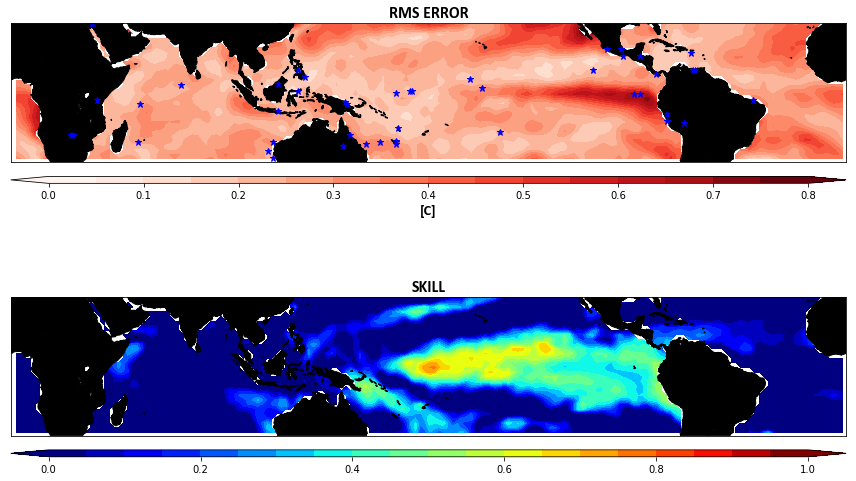

In [45]:
fig = plt.figure(figsize=(12,8))
m = Basemap(projection='cyl',lon_0=-180.,lat_0=0.,llcrnrlat=-30.,urcrnrlat=30.,llcrnrlon=-360.,\
            urcrnrlon=0.,resolution='l')

#RMS ERROR
meanRMS2 = meanRMS.reshape(I,J,order='F')
meanRMS2[meanRMS2<0.1] = np.nan
ax = fig.add_subplot(211)
cmin = 0; cmax = 0.81; cint = 0.05; clevs = np.round(np.arange(cmin,cmax,cint),2)
nlevs = len(clevs) - 1; cmap = plt.get_cmap(name='Reds',lut=nlevs)
m.drawcoastlines(); m.fillcontinents(color='Black')
plotX,plotY = m(sstlon,sstlat)
cs = m.contourf(plotX,plotY,meanRMS2,clevs,cmap=cmap,extend='both')
plotX2,plotY2 = m(proxylon,proxylat)
m.plot(plotX2,plotY2,'b*',markersize=7)
cbar = m.colorbar(cs,pad='10%',location='bottom')
cbar.ax.set_xlabel('[C]',weight='bold',name='Calibri',size=14)

cbar.set_ticks(clevs[::2])
cbar.set_ticklabels(clevs[::2])
    
for i in cbar.ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(14)
    
ax.set_title('RMS ERROR',name='Calibri',weight='bold',size=16)

#SKILL
ax = fig.add_subplot(212)
cmin = 0; cmax = 1.05; cint = 0.05; clevs = np.round(np.arange(cmin,cmax,cint),2)
nlevs = len(clevs) - 1; cmap = plt.get_cmap(name='jet',lut=nlevs)
m.drawcoastlines(); m.fillcontinents(color='Black')
cs = m.contourf(plotX,plotY,skill,clevs,cmap=cmap,extend='both')
cbar = m.colorbar(cs,pad='10%',location='bottom')

cbar.set_ticks(clevs[::4])
cbar.set_ticklabels(clevs[::4])

for i in cbar.ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(14)

ax.set_title('SKILL',name='Calibri',weight='bold',size=16)

fig.tight_layout()
plt.show(block=False)

#outFile = 'COVMODEL_SKILL.png'
#plt.savefig(outFile,dpi=400)
